# Data Preprocessing for Revenue

For: Pao Pao and Suhut Mickey Lin

This file takes in non-text data files in the data folder and aggregate it into train and test files for the *model_*.ipynb* files. This is the most time sensitive. I'll make sure this is done before Wednesday 23rd Apr 2025 (I know that this is extremely late sorry). For now the code below generates a test file for yall to test out the code for the models. The performance will probably be bad but as long as the code runs that is good enough.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from companies import large_banks, medium_banks, small_banks

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Start with revenue data

df_revenue = pd.read_csv('data/fundamentals/banking_fundamental_drive.csv')
df_revenue["cik"] = df_revenue["cik"].astype(str)
df_revenue["datacqtr"] = pd.to_datetime(df_revenue["datacqtr"])
df_revenue['datacqtr'] = df_revenue['datacqtr'].dt.to_period('Q')
df_revenue = df_revenue.rename(columns={"tcorq": "Total Current Operating Revenue"})

In [5]:
df_revenue = df_revenue[["datacqtr", "tic", "apdedateq", "Total Current Operating Revenue"]]
df_revenue.head()

,datacqtr,tic,apdedateq,Total Current Operating Revenue
0,2001Q1,ASO.1,NaN,882.118
1,2001Q2,ASO.1,NaN,866.228
2,2001Q3,ASO.1,NaN,840.719
3,2001Q4,ASO.1,NaN,793.697
4,2002Q1,ASO.1,NaN,748.219


In [6]:
all_banks = large_banks + medium_banks + small_banks

# Filter the dataframe to only include the banks in all_banks
df_revenue = df_revenue[df_revenue["tic"].isin(all_banks)]

In [7]:
# Check for nan values in each column
df_revenue.isna().sum()

datacqtr                              2
tic                                   0
apdedateq                          1217
Total Current Operating Revenue     114
dtype: int64

In [8]:
# Drop values with nan
df_revenue = df_revenue.dropna()

In [9]:
# Check for duplucate datacqtr and tic
df_revenue.duplicated(subset=["datacqtr", "tic"]).sum()

0

In [10]:
# Find the min and max date
df_revenue["datacqtr"].min(), df_revenue["datacqtr"].max()

(Period('2002Q4', 'Q-DEC'), Period('2024Q4', 'Q-DEC'))

In [11]:
len(df_revenue)

9224

In [12]:
# sort dataframe by datacqtr and tic
df_revenue = df_revenue.sort_values(by=["tic", "datacqtr"], ascending=[True, True])
df_revenue = df_revenue.reset_index(drop=True)

In [13]:
df_revenue.head()

,datacqtr,tic,apdedateq,Total Current Operating Revenue
0,2003Q2,ABVA,06/30/2003,5.723
1,2003Q3,ABVA,09/30/2003,5.851
2,2003Q4,ABVA,12/31/2003,5.352
3,2004Q1,ABVA,03/31/2004,5.217
4,2004Q2,ABVA,06/30/2004,6.016


In [14]:
evtdate = pd.to_datetime(df_revenue['apdedateq']).dt.date.unique().tolist()

In [15]:
df_revenue_2 = df_revenue.copy()
df_revenue_2.rename(columns={"apdedateq": "evtdate"}, inplace=True)
df_revenue_2["evtdate"] = pd.to_datetime(df_revenue_2["evtdate"]).dt.strftime('%Y-%m-%d')
df_revenue_2["evtdate"] = pd.to_datetime(df_revenue_2["evtdate"]).dt.date

In [16]:
df_revenue = df_revenue[["datacqtr", "tic", "Total Current Operating Revenue"]]

## ECON SECTION

In [17]:
# Now we calculate the econ data
econ_path = "data/econ_data"

### Feature 1: GDP

In [18]:
df_gdp = pd.read_csv(f"{econ_path}/GDP.csv")  # https://fred.stlouisfed.org/series/GDP (QUARTERLY)
df_gdp = df_gdp.rename(columns={"GDP":"GDP (BILLIONS OF DOLLARS)"})
df_gdp["GDP CHANGE (-1 to 1)"] = df_gdp["GDP (BILLIONS OF DOLLARS)"].pct_change()
df_gdp['observation_date'] = pd.to_datetime(df_gdp['observation_date'])
df_gdp['datacqtr'] = df_gdp['observation_date'].dt.to_period('Q')
df_gdp = df_gdp[["datacqtr", "GDP CHANGE (-1 to 1)"]]

In [19]:
# Find the first and last quarter year
first_quarter = df_gdp['datacqtr'].min()
last_quarter = df_gdp['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

First quarter: 1947Q1, Last quarter: 2024Q4


In [20]:
# left join the GDP data with the CAR data
df_revenue = df_revenue.merge(df_gdp, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in GDP data: {df_revenue['GDP CHANGE (-1 to 1)'].isna().sum()}")

9224
Number of NaN values in GDP data: 0


### Feature 2: Unemployment rate

In [21]:
df_unrate = pd.read_csv(f"{econ_path}/UNRATE.csv")  # https://fred.stlouisfed.org/series/UNRATE (MONTHLY)
df_unrate = df_unrate.rename(columns={"UNRATE":"UNEMPLOYMENT RATE (0 to 1)"})
df_unrate["UNEMPLOYMENT RATE (0 to 1)"] = df_unrate["UNEMPLOYMENT RATE (0 to 1)"] / 100
df_unrate['observation_date'] = pd.to_datetime(df_unrate['observation_date'])
df_unrate['datacqtr'] = df_unrate['observation_date'].dt.to_period('Q')
df_unrate = df_unrate.groupby('datacqtr')['UNEMPLOYMENT RATE (0 to 1)'].mean().reset_index()
df_unrate = df_unrate[["datacqtr", "UNEMPLOYMENT RATE (0 to 1)"]]

In [22]:
# left join the unrate data with the CAR data
df_revenue = df_revenue.merge(df_unrate, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Unemployment data: {df_revenue['UNEMPLOYMENT RATE (0 to 1)'].isna().sum()}")

9224
Number of NaN values in Unemployment data: 0


### Feature 3: Prime Loan Rate

In [23]:
df_dprime = pd.read_csv(f"{econ_path}/DPRIME.csv")  # https://fred.stlouisfed.org/series/DPRIME (DAILY)
df_dprime = df_dprime.rename(columns={"DPRIME": "PRIME LOAN RATE (0 to 1)"})
df_dprime["PRIME LOAN RATE (0 to 1)"] = df_dprime["PRIME LOAN RATE (0 to 1)"] / 100
df_dprime['observation_date'] = pd.to_datetime(df_dprime['observation_date'])
df_dprime['datacqtr'] = df_dprime['observation_date'].dt.to_period('Q')
df_dprime = df_dprime.groupby('datacqtr')['PRIME LOAN RATE (0 to 1)'].mean().reset_index()
df_dprime = df_dprime[["datacqtr", "PRIME LOAN RATE (0 to 1)"]]

In [24]:
# left join the dprime data with the CAR data
df_revenue = df_revenue.merge(df_dprime, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Prime Loan Rate data: {df_revenue['PRIME LOAN RATE (0 to 1)'].isna().sum()}")

9224
Number of NaN values in Prime Loan Rate data: 0


### Feature 4: Deposits

In [25]:
df_deposit = pd.read_csv(f"{econ_path}/DEPOSITS.csv")  # https://fred.stlouisfed.org/series/DPSACBW027SBOG (WEEKLY)
df_deposit = df_deposit.rename(columns={"DPSACBW027SBOG":"DEPOSITS (BILLIONS OF DOLLARS)"})
df_deposit['observation_date'] = pd.to_datetime(df_deposit['observation_date'])
df_deposit['datacqtr'] = df_deposit['observation_date'].dt.to_period('Q')
df_deposit = df_deposit.groupby('datacqtr')['DEPOSITS (BILLIONS OF DOLLARS)'].mean().reset_index()
df_deposit["DEPOSITS CHANGE (-1 to 1)"] = df_deposit["DEPOSITS (BILLIONS OF DOLLARS)"].pct_change()
df_deposit = df_deposit[["datacqtr", "DEPOSITS CHANGE (-1 to 1)"]]

In [26]:
# Join the deposits data with the CAR data
df_revenue = df_revenue.merge(df_deposit, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Deposits data: {df_revenue['DEPOSITS CHANGE (-1 to 1)'].isna().sum()}")

9224
Number of NaN values in Deposits data: 0


### Feature 5: Consumer Price Index (Inflation)

In [27]:
df_inflation = pd.read_csv(f"{econ_path}/INFLATION.csv")  # https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL (MONTHLY)
df_inflation = df_inflation.rename(columns={"CORESTICKM159SFRBATL":"CONSUMER PRICE INDEX (0 to 1)"})
df_inflation["CONSUMER PRICE INDEX (0 to 1)"] = df_inflation["CONSUMER PRICE INDEX (0 to 1)"] / 100
df_inflation['observation_date'] = pd.to_datetime(df_inflation['observation_date'])
df_inflation['datacqtr'] = df_inflation['observation_date'].dt.to_period('Q')
df_inflation = df_inflation.groupby('datacqtr')['CONSUMER PRICE INDEX (0 to 1)'].mean().reset_index()
df_inflation = df_inflation[["datacqtr", "CONSUMER PRICE INDEX (0 to 1)"]]


In [28]:
# Left join the inflation data with the CAR data
df_revenue = df_revenue.merge(df_inflation, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Inflation data: {df_revenue['CONSUMER PRICE INDEX (0 to 1)'].isna().sum()}")

9224
Number of NaN values in Inflation data: 0


### Feature 6: Savings

In [29]:
df_savings = pd.read_csv(f"{econ_path}/SAVINGS.csv")  # https://fred.stlouisfed.org/series/W207RC1Q156SBEA (Quarterly)
df_savings = df_savings.rename(columns={"W207RC1Q156SBEA":"SAVINGS PER GROSS INCOME (-1 to 1)"})
df_savings["SAVINGS PER GROSS INCOME (-1 to 1)"] = df_savings["SAVINGS PER GROSS INCOME (-1 to 1)"] / 100
df_savings['observation_date'] = pd.to_datetime(df_savings['observation_date'])
df_savings['datacqtr'] = df_savings['observation_date'].dt.to_period('Q')
df_savings = df_savings[["datacqtr", "SAVINGS PER GROSS INCOME (-1 to 1)"]]

In [30]:
# Join the savings data with the CAR data
df_revenue = df_revenue.merge(df_savings, on=["datacqtr"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Savings data: {df_revenue['SAVINGS PER GROSS INCOME (-1 to 1)'].isna().sum()}")

9224
Number of NaN values in Savings data: 0


## Fundamentals Section

In [31]:
from utililties import interpolate_missing_values, fill_with_industry_average, get_bank_peers, check_if_all_nan_by_ticker

In [32]:
fundamentals_path = "data/fundamentals"

df_fundamentals = pd.read_csv(f"{fundamentals_path}/fundamentals_banking.csv")
df_fundamentals["cik"] = df_fundamentals["cik"].astype(str)
df_fundamentals["datacqtr"] = pd.to_datetime(df_fundamentals["datacqtr"])
df_fundamentals['datacqtr'] = df_fundamentals['datacqtr'].dt.to_period('Q')

In [33]:
interested_cols = ["niitq", "nimq", "ncoq", "cheq", "niq"]  # finrevq
name_map = {"niitq": "Net Interest Income", "nimq": "Net Interest Margin", "ncoq": "Net Charge-Offs", "cheq": "Cash and Short-Term Investments", "niq": "Net Income"}
key_cols = ["datacqtr", "datadate", "rdq", "tic", "cik",]

# Check if any columns cant be found
for col in interested_cols:
    if col not in df_fundamentals.columns:
        print(col)

In [34]:
df_fundamentals_simplified = df_fundamentals[key_cols + interested_cols]
df_fundamentals_simplified = df_fundamentals_simplified.rename(columns=name_map)

# Check if any columns are all NaN
nan_columns = df_fundamentals_simplified.columns[df_fundamentals_simplified.isna().all()].tolist()
print("Columns with only NaN values:", nan_columns)

Columns with only NaN values: []


In [35]:
df_fundamentals_simplified = df_fundamentals_simplified.sort_values(by=["tic", "datacqtr"], ascending=[True, True])
df_fundamentals_simplified = df_fundamentals_simplified.reset_index(drop=True)
df_fundamentals_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income
0,2002Q1,31/03/2002,NaN,ABVA,1181001.0,1.400,NaN,0.005,NaN,0.268
1,2002Q2,30/06/2002,31/07/2002,ABVA,1181001.0,1.600,NaN,-0.018,NaN,0.452
2,2002Q3,30/09/2002,14/11/2002,ABVA,1181001.0,1.900,3.87,-0.008,54.513,0.876
3,2002Q4,31/12/2002,03/02/2003,ABVA,1181001.0,2.238,4.01,-0.001,27.342,0.826
4,2003Q1,31/03/2003,07/05/2003,ABVA,1181001.0,2.300,3.53,0.000,55.380,1.124


In [36]:
for ticker in df_fundamentals_simplified["tic"].unique():
    # Lag the data by 1 quarter
    df_fundamentals_simplified.loc[df_fundamentals_simplified["tic"] == ticker, "datacqtr"] = df_fundamentals_simplified.loc[df_fundamentals_simplified["tic"] == ticker, "datacqtr"].shift(-1)

In [37]:
df_fundamentals_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income
0,2002Q2,31/03/2002,NaN,ABVA,1181001.0,1.400,NaN,0.005,NaN,0.268
1,2002Q3,30/06/2002,31/07/2002,ABVA,1181001.0,1.600,NaN,-0.018,NaN,0.452
2,2002Q4,30/09/2002,14/11/2002,ABVA,1181001.0,1.900,3.87,-0.008,54.513,0.876
3,2003Q1,31/12/2002,03/02/2003,ABVA,1181001.0,2.238,4.01,-0.001,27.342,0.826
4,2003Q2,31/03/2003,07/05/2003,ABVA,1181001.0,2.300,3.53,0.000,55.380,1.124


In [38]:
# Get the first and last quarter of the fundamentals data

first_quarter = df_fundamentals_simplified['datacqtr'].min()
last_quarter = df_fundamentals_simplified['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

# count number of quarters
print(f"Number of quarters in the data: {len(df_fundamentals_simplified['datacqtr'].unique())}")

First quarter: 2000Q2, Last quarter: 2024Q4
Number of quarters in the data: 100


In [39]:
# Filter Rev data to match the range of the fundamentals data
df_revenue = df_revenue[(df_revenue['datacqtr'] >= first_quarter) & (df_revenue['datacqtr'] <= last_quarter)]
# Check length
print(len(df_revenue))

9224


### Feature 7: Net Interest Income

In [40]:
df_net_interest_income = df_fundamentals_simplified[["datacqtr", "tic", "Net Interest Income"]]

In [41]:
# Drop rows with datacqtr as NaN
df_net_interest_income = df_net_interest_income.dropna(subset=["datacqtr"])
# Check length
print(len(df_net_interest_income))  # we do not want to lose any rows

11353


In [42]:
# For each ticker, add rows from the Rev data to match tic and datacqtr
df_net_interest_income = df_net_interest_income.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

In [43]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr                  0
tic                       0
Net Interest Income    3071
dtype: int64
Number of rows in Net Interest Income data: 11366


In [44]:
empty_tickers = check_if_all_nan_by_ticker(df_net_interest_income, 'Net Interest Income')
for ticker in empty_tickers:
    df_net_interest_income = fill_with_industry_average(df_net_interest_income, ticker, get_bank_peers(ticker), 'Net Interest Income')
len(df_net_interest_income)

11366

In [45]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr                  0
tic                       0
Net Interest Income    1902
dtype: int64
Number of rows in Net Interest Income data: 11366


In [46]:
df_net_interest_income = interpolate_missing_values(df_net_interest_income, 'Net Interest Income')

In [47]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr               0
tic                    0
Net Interest Income    0
dtype: int64
Number of rows in Net Interest Income data: 11366


In [48]:
# Join net interest income data with the CAR data
df_revenue = df_revenue.merge(df_net_interest_income, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### Feature 8: Net Interest Margin

In [49]:
df_net_interest_margin = df_fundamentals_simplified[["datacqtr", "tic", "Net Interest Margin"]]

In [50]:
# Drop rows with datacqtr as NaN
df_net_interest_margin = df_net_interest_margin.dropna(subset=["datacqtr"])
# Check length
print(len(df_net_interest_margin))  # we do not want to lose any rows

11353


In [51]:
# For each ticker, add rows from the REV data to match tic and datacqtr
df_net_interest_margin = df_net_interest_margin.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

In [52]:
empty_tickers = check_if_all_nan_by_ticker(df_net_interest_margin, 'Net Interest Margin')
for ticker in empty_tickers:
    df_net_interest_margin = fill_with_industry_average(df_net_interest_margin, ticker, get_bank_peers(ticker), 'Net Interest Margin')
len(df_net_interest_margin)

11366

In [53]:
df_net_interest_margin = interpolate_missing_values(df_net_interest_margin, 'Net Interest Margin')

In [54]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Margin data:\n", df_net_interest_margin.isna().sum())
# Number of rows
print("Number of rows in Net Interest Margin data:", len(df_net_interest_margin))

Number of NaN values in Net Interest Margin data:
 datacqtr               0
tic                    0
Net Interest Margin    0
dtype: int64
Number of rows in Net Interest Margin data: 11366


In [55]:
# Join net interest margin data with the CAR data
df_revenue = df_revenue.merge(df_net_interest_margin, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### Feature 9: Net Charge-Offs

In [56]:
feature = "Net Charge-Offs"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Charge-Offs data:
 datacqtr             0
tic                  0
Net Charge-Offs    922
dtype: int64
Number of rows in Net Charge-Offs data: 11366


In [57]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11366

In [58]:
df_feature = interpolate_missing_values(df_feature, feature)

In [59]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Charge-Offs data:
 datacqtr           0
tic                0
Net Charge-Offs    0
dtype: int64
Number of rows in Net Charge-Offs data: 11366


In [60]:
# Join net interest margin data with the CAR data
df_revenue = df_revenue.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### Feature 10: Cash and Short-Term Investments

In [61]:
feature = "Cash and Short-Term Investments"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Cash and Short-Term Investments data:
 datacqtr                             0
tic                                  0
Cash and Short-Term Investments    255
dtype: int64
Number of rows in Cash and Short-Term Investments data: 11366


In [62]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11366

In [63]:
df_feature = interpolate_missing_values(df_feature, feature)

In [64]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Cash and Short-Term Investments data:
 datacqtr                           0
tic                                0
Cash and Short-Term Investments    0
dtype: int64
Number of rows in Cash and Short-Term Investments data: 11366


In [65]:
# Join net interest margin data with the CAR data
df_revenue = df_revenue.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### Feature 11: Net Income

In [66]:
feature = "Net Income"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Income data:
 datacqtr        0
tic             0
Net Income    110
dtype: int64
Number of rows in Net Income data: 11366


In [67]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11366

In [68]:
df_feature = interpolate_missing_values(df_feature, feature)

In [69]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Income data:
 datacqtr      0
tic           0
Net Income    0
dtype: int64
Number of rows in Net Income data: 11366


In [70]:
# Join net interest margin data with the CAR data
df_revenue = df_revenue.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


## Second Fundamentals File

In [71]:
df_bank_fundamentals_drive = pd.read_csv(f"{fundamentals_path}/banking_fundamental_drive.csv")
df_bank_fundamentals_drive["cik"] = df_bank_fundamentals_drive["cik"].astype(str)
df_bank_fundamentals_drive["datacqtr"] = pd.to_datetime(df_bank_fundamentals_drive["datacqtr"])
df_bank_fundamentals_drive['datacqtr'] = df_bank_fundamentals_drive['datacqtr'].dt.to_period('Q')

In [72]:
interested_cols_2 = ["dibq", "dpscq", "dptcq", "icaptq", "iditq"]
name_map_2 = {"dibq": "Deposits - Interest Bearing", "dpscq": "Total Savings Deposits", "dptcq": "Deposits - Total", "icaptq": "Invested Capital - Total", "iditq": "Interest Income - Total"}

# Deposits - Interest Bearing (dibq)
# Total Savings Deposits (dpscq)
# Deposits - Total (dptcq)
# Invested Capital - Total (icaptq)
# Interest Income - Total (iditq)
# Total Domestic Deposits (tdomdq)
# Total Foreign Deposits (tfdq)

# Total Current Operating Revenue ("tcorq")

In [73]:
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive[key_cols + interested_cols_2]
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive_simplified.rename(columns=name_map_2)

In [74]:
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive_simplified.sort_values(by=["tic", "datacqtr"], ascending=[True, True])
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive_simplified.reset_index(drop=True)
df_bank_fundamentals_drive_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Deposits - Interest Bearing,Total Savings Deposits,Deposits - Total,Invested Capital - Total,Interest Income - Total
0,2001Q1,03/31/2001,04/18/2001,0176A,1011659.0,15980.784,NaN,27208.128,4440.149,608.692
1,2001Q2,06/30/2001,07/18/2001,0176A,1011659.0,16110.140,NaN,27700.624,4640.344,563.121
2,2001Q3,09/30/2001,10/17/2001,0176A,1011659.0,15466.494,NaN,27065.423,4639.950,536.001
3,2001Q4,12/31/2001,01/17/2002,0176A,1011659.0,15837.341,NaN,28556.199,5010.573,487.497
4,2002Q1,03/31/2002,04/17/2002,0176A,1011659.0,16475.703,NaN,28758.849,5228.438,462.380


In [75]:
for ticker in df_bank_fundamentals_drive_simplified["tic"].unique():
    # Lag the data by 1 quarter
    df_bank_fundamentals_drive_simplified.loc[df_bank_fundamentals_drive_simplified["tic"] == ticker, "datacqtr"] = df_bank_fundamentals_drive_simplified.loc[df_bank_fundamentals_drive_simplified["tic"] == ticker, "datacqtr"].shift(-1)

In [76]:
df_bank_fundamentals_drive_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Deposits - Interest Bearing,Total Savings Deposits,Deposits - Total,Invested Capital - Total,Interest Income - Total
0,2001Q2,03/31/2001,04/18/2001,0176A,1011659.0,15980.784,NaN,27208.128,4440.149,608.692
1,2001Q3,06/30/2001,07/18/2001,0176A,1011659.0,16110.140,NaN,27700.624,4640.344,563.121
2,2001Q4,09/30/2001,10/17/2001,0176A,1011659.0,15466.494,NaN,27065.423,4639.950,536.001
3,2002Q1,12/31/2001,01/17/2002,0176A,1011659.0,15837.341,NaN,28556.199,5010.573,487.497
4,2002Q2,03/31/2002,04/17/2002,0176A,1011659.0,16475.703,NaN,28758.849,5228.438,462.380


In [77]:
len(df_bank_fundamentals_drive_simplified)

69586

In [78]:
# Get the first and last quarter of the fundamentals data

first_quarter = df_bank_fundamentals_drive_simplified['datacqtr'].min()
last_quarter = df_bank_fundamentals_drive_simplified['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

# count number of quarters
print(f"Number of quarters in the data: {len(df_bank_fundamentals_drive_simplified['datacqtr'].unique())}")

First quarter: 2001Q1, Last quarter: 2024Q4
Number of quarters in the data: 97


### SKIP TOTAL SAVINGS DEPOSITS AND DEPOSITS - INTEREST BEARING

### Feature 14: Invested Capital - Total

In [79]:
feature = "Invested Capital - Total"
df_feature = df_bank_fundamentals_drive_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.dropna(subset=["tic"])
df_feature = df_feature.merge(df_revenue[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Invested Capital - Total data:
 datacqtr                       0
tic                            0
Invested Capital - Total    5808
dtype: int64
Number of rows in Invested Capital - Total data: 67968


In [80]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    if (ticker not in large_banks) and (ticker not in medium_banks) and (ticker not in small_banks):
        continue 
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

67968

In [81]:
df_feature = interpolate_missing_values(df_feature, feature)

In [82]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Invested Capital - Total data:
 datacqtr                    0
tic                         0
Invested Capital - Total    0
dtype: int64
Number of rows in Invested Capital - Total data: 67968


In [83]:
# Join net interest margin data with the CAR data
df_revenue = df_revenue.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


## Other market data as features

In [84]:
from utililties import forward_fill_dates

In [85]:
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

In [86]:
tickers = df_revenue['tic'].unique()

In [87]:
# get min and max date
min_date = df_revenue['datacqtr'].min().to_timestamp()
max_date = df_revenue['datacqtr'].max().to_timestamp()
print(f"Min date: {min_date}, Max date: {max_date}")

Min date: 2002-10-01 00:00:00, Max date: 2024-10-01 00:00:00


In [88]:
# Adjust mindate to 1 year before the min date
min_date = min_date - pd.DateOffset(years=1)
max_date = max_date + pd.DateOffset(years=1)

### S&P500

In [89]:
# Download S&P 500 data
ticker_obj = yf.Ticker("^GSPC")
sp500 = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=sp500['Close'], window=20, fillna=True)
sp500['S&P_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=sp500['Close'], window=40, fillna=True)
sp500['S&P_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=sp500['Close'], window=60, fillna=True)
sp500['S&P_SMA60'] = sma_long.sma_indicator()

# RSI
rsi = RSIIndicator(close=sp500['Close'], window=40, fillna=True)
sp500['S&P_RSI'] = rsi.rsi() / 100

# Now calculate normalized SMAs according to your formula
# For each point, normalize by the oldest value in the window

# Normalized SMA 20
sp500['S&P_SMA20'] = sp500['S&P_SMA20'] / (sp500['Close'].shift(19)) - 1

# Normalized SMA 40
sp500['S&P_SMA40'] = sp500['S&P_SMA40'] / (sp500['Close'].shift(39)) - 1

# Normalized SMA 60
sp500['S&P_SMA60'] = sp500['S&P_SMA60'] / (sp500['Close'].shift(59)) - 1

In [90]:
# Reset index and get dataqtr
sp500 = sp500.reset_index()
sp500 = forward_fill_dates(sp500, 'Date')

sp500['evtdate'] = pd.to_datetime(sp500['Date']).dt.date

# Take only date that is in evtdate
sp500 = sp500[sp500['evtdate'].isin(evtdate)]
sp500 = sp500[['evtdate', 'S&P_SMA20', 'S&P_SMA40', 'S&P_SMA60', 'S&P_RSI']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(sp500, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'S&P_SMA20', 'S&P_SMA40', 'S&P_SMA60', 'S&P_RSI']]

In [91]:
len(evtdate)

92

In [92]:
# drop duplicates from df_car_2 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])

In [93]:
# Join CAR data with S&P 500 data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### ^TNX

In [94]:
# Download TNX data
ticker_obj = yf.Ticker("^TNX")
tnx = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=tnx['Close'], window=20, fillna=True)
tnx['TNX_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=tnx['Close'], window=40, fillna=True)
tnx['TNX_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=tnx['Close'], window=60, fillna=True)
tnx['TNX_SMA60'] = sma_long.sma_indicator()

# Normalized SMA 20
tnx['TNX_SMA20'] = tnx['TNX_SMA20'] / (tnx['Close'].shift(19)) - 1

# Normalized SMA 40
tnx['TNX_SMA40'] = tnx['TNX_SMA40'] / (tnx['Close'].shift(39)) - 1

# Normalized SMA 60
tnx['TNX_SMA60'] = tnx['TNX_SMA60'] / (tnx['Close'].shift(59)) - 1

In [95]:
# Reset index and get dataqtr
tnx = tnx.reset_index()
tnx = forward_fill_dates(tnx, 'Date')

tnx['evtdate'] = pd.to_datetime(tnx['Date']).dt.date

# Take only date that is in evtdate
tnx = tnx[tnx['evtdate'].isin(evtdate)]
tnx = tnx[['evtdate', 'TNX_SMA20', 'TNX_SMA40', 'TNX_SMA60']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(tnx, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'TNX_SMA20', 'TNX_SMA40', 'TNX_SMA60']]

In [96]:
# drop duplicates from df_car_2 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])

In [97]:
# Join CAR data with S&P 500 data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### ^IRX

In [98]:
# Download IRX data
ticker_obj = yf.Ticker("^IRX")
irx = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=irx['Close'], window=20, fillna=True)
irx['IRX_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=irx['Close'], window=40, fillna=True)
irx['IRX_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=irx['Close'], window=60, fillna=True)
irx['IRX_SMA60'] = sma_long.sma_indicator()

# Normalized SMA 20
irx['IRX_SMA20'] = irx['IRX_SMA20'] / (irx['Close'].shift(19)) - 1

# Normalized SMA 40
irx['IRX_SMA40'] = irx['IRX_SMA40'] / (irx['Close'].shift(39)) - 1

# Normalized SMA 60
irx['IRX_SMA60'] = irx['IRX_SMA60'] / (irx['Close'].shift(59)) - 1

In [99]:
# Reset index and get dataqtr
irx = irx.reset_index()
irx = forward_fill_dates(irx, 'Date')

irx['evtdate'] = pd.to_datetime(irx['Date']).dt.date

# Take only date that is in evtdate
irx = irx[irx['evtdate'].isin(evtdate)]
irx = irx[['evtdate', 'IRX_SMA20', 'IRX_SMA40', 'IRX_SMA60']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(irx, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'IRX_SMA20', 'IRX_SMA40', 'IRX_SMA60']]

In [100]:
# drop duplicates from df_car_2 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])

In [101]:
# Join CAR data with S&P 500 data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


In [102]:
df_revenue

,datacqtr,tic,Total Current Operating Revenue,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,...,S&P_SMA20,S&P_SMA40,S&P_SMA60,S&P_RSI,TNX_SMA20,TNX_SMA40,TNX_SMA60,IRX_SMA20,IRX_SMA40,IRX_SMA60
0,2003Q2,ABVA,5.723,0.012407,0.061333,0.042422,0.019583,0.023503,0.023,2.300,...,0.017997,0.040331,0.071056,0.557892,-0.007092,-0.120453,-0.089114,-0.154237,-0.103228,-0.049646
1,2003Q3,ABVA,5.851,0.022444,0.061333,0.040000,0.024575,0.021859,0.022,2.400,...,-0.006777,0.041614,-0.006817,0.507058,-0.076973,-0.021347,0.138838,-0.024948,0.000508,0.043220
2,2003Q4,ABVA,5.352,0.017772,0.058333,0.040000,0.000658,0.020481,0.026,2.700,...,0.016091,0.012653,0.018528,0.632262,-0.037097,-0.022247,0.031001,-0.034156,-0.021227,0.000350
3,2004Q1,ABVA,5.217,0.012845,0.057000,0.040000,0.024246,0.020378,0.025,2.440,...,-0.030393,0.005397,0.008524,0.523814,-0.061392,-0.049570,-0.069207,-0.014825,0.012281,0.007251
4,2004Q2,ABVA,6.016,0.015882,0.056000,0.040039,0.036984,0.022824,0.029,2.603,...,0.007418,-0.001250,-0.024191,0.540706,-0.001279,0.038625,0.090371,0.097592,0.150532,0.171199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9219,2023Q4,ZION,1189.000,0.011773,0.038000,0.085000,0.001773,0.047105,0.013,596.000,...,0.019680,0.060293,0.050946,0.633902,-0.048095,-0.088317,-0.058759,0.001735,-0.005840,-0.011039
9220,2024Q1,ZION,1212.000,0.011560,0.038333,0.085000,0.006771,0.045014,0.014,593.000,...,0.006520,0.037723,0.062041,0.650677,0.006723,0.089801,0.064751,0.002387,0.005144,-0.002655
9221,2024Q2,ZION,1248.000,0.013717,0.040000,0.085000,0.005864,0.043128,0.011,596.000,...,0.024775,0.051717,0.019570,0.623798,-0.043963,-0.038476,0.033473,-0.002316,-0.000095,0.006589
9222,2024Q3,ZION,1267.000,0.012345,0.041667,0.084375,0.004837,0.041015,0.002,608.000,...,0.016699,0.070857,-0.005016,0.592845,-0.032349,0.002470,-0.080917,-0.052998,-0.037381,-0.047288


### ^FVX

In [103]:
# Download FVX data
ticker_obj = yf.Ticker("^FVX")
fvx = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=fvx['Close'], window=20, fillna=True)
fvx['FVX_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=fvx['Close'], window=40, fillna=True)
fvx['FVX_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=fvx['Close'], window=60, fillna=True)
fvx['FVX_SMA60'] = sma_long.sma_indicator()

# Normalized SMA 20
fvx['FVX_SMA20'] = fvx['FVX_SMA20'] / (fvx['Close'].shift(19)) - 1

# Normalized SMA 40
fvx['FVX_SMA40'] = fvx['FVX_SMA40'] / (fvx['Close'].shift(39)) - 1

# Normalized SMA 60
fvx['FVX_SMA60'] = fvx['FVX_SMA60'] / (fvx['Close'].shift(59)) - 1


# Reset index and get dataqtr
fvx = fvx.reset_index()
fvx = forward_fill_dates(fvx, 'Date')

fvx['evtdate'] = pd.to_datetime(fvx['Date']).dt.date

# Take only date that is in evtdate
fvx = fvx[fvx['evtdate'].isin(evtdate)]
fvx = fvx[['evtdate', 'FVX_SMA20', 'FVX_SMA40', 'FVX_SMA60']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(fvx, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'FVX_SMA20', 'FVX_SMA40', 'FVX_SMA60']]


# drop duplicates from df_revenue_3 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])


# Join data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### ^TYX

In [104]:
# Download TYX data
ticker_obj = yf.Ticker("^TYX")
tyx = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=tyx['Close'], window=20, fillna=True)
tyx['TYX_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=tyx['Close'], window=40, fillna=True)
tyx['TYX_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=tyx['Close'], window=60, fillna=True)
tyx['TYX_SMA60'] = sma_long.sma_indicator()

# Normalized SMA 20
tyx['TYX_SMA20'] = tyx['TYX_SMA20'] / (tyx['Close'].shift(19)) - 1

# Normalized SMA 40
tyx['TYX_SMA40'] = tyx['TYX_SMA40'] / (tyx['Close'].shift(39)) - 1

# Normalized SMA 60
tyx['TYX_SMA60'] = tyx['TYX_SMA60'] / (tyx['Close'].shift(59)) - 1


# Reset index and get dataqtr
tyx = tyx.reset_index()
tyx = forward_fill_dates(tyx, 'Date')

tyx['evtdate'] = pd.to_datetime(tyx['Date']).dt.date

# Take only date that is in evtdate
tyx = tyx[tyx['evtdate'].isin(evtdate)]
tyx = tyx[['evtdate', 'TYX_SMA20', 'TYX_SMA40', 'TYX_SMA60']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(tyx, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'TYX_SMA20', 'TYX_SMA40', 'TYX_SMA60']]


# drop duplicates from df_revenue_3 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])


# Join data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### ^DXY

In [105]:
# Download DXY data
ticker_obj = yf.Ticker("DX-Y.NYB")  # Yahoo Finance ticker for US Dollar Index
dxy = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=dxy['Close'], window=20, fillna=True)
dxy['DXY_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=dxy['Close'], window=40, fillna=True)
dxy['DXY_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=dxy['Close'], window=60, fillna=True)
dxy['DXY_SMA60'] = sma_long.sma_indicator()

# Normalized SMA 20
dxy['DXY_SMA20'] = dxy['DXY_SMA20'] / (dxy['Close'].shift(19)) - 1

# Normalized SMA 40
dxy['DXY_SMA40'] = dxy['DXY_SMA40'] / (dxy['Close'].shift(39)) - 1

# Normalized SMA 60
dxy['DXY_SMA60'] = dxy['DXY_SMA60'] / (dxy['Close'].shift(59)) - 1


# Reset index and get dataqtr
dxy = dxy.reset_index()
dxy = forward_fill_dates(dxy, 'Date')

dxy['evtdate'] = pd.to_datetime(dxy['Date']).dt.date

# Take only date that is in evtdate
dxy = dxy[dxy['evtdate'].isin(evtdate)]
dxy = dxy[['evtdate', 'DXY_SMA20', 'DXY_SMA40', 'DXY_SMA60']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(dxy, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'DXY_SMA20', 'DXY_SMA40', 'DXY_SMA60']]


# drop duplicates from df_revenue_3 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])


# Join data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### ^XLF

In [106]:
# Download XLF data instead of S&P 500
ticker_obj = yf.Ticker("XLF")
xlf = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 20
sma_short = SMAIndicator(close=xlf['Close'], window=20, fillna=True)
xlf['XLF_SMA20'] = sma_short.sma_indicator()

# SMA 40
sma_mid = SMAIndicator(close=xlf['Close'], window=40, fillna=True)
xlf['XLF_SMA40'] = sma_mid.sma_indicator()

# SMA 60
sma_long = SMAIndicator(close=xlf['Close'], window=60, fillna=True)
xlf['XLF_SMA60'] = sma_long.sma_indicator()

# RSI
rsi = RSIIndicator(close=xlf['Close'], window=40, fillna=True)
xlf['XLF_RSI'] = rsi.rsi() / 100

# Now calculate normalized SMAs according to your formula
# Normalized SMA 20
xlf['XLF_SMA20'] = xlf['XLF_SMA20'] / (xlf['Close'].shift(19)) - 1

# Normalized SMA 40
xlf['XLF_SMA40'] = xlf['XLF_SMA40'] / (xlf['Close'].shift(39)) - 1

# Normalized SMA 60
xlf['XLF_SMA60'] = xlf['XLF_SMA60'] / (xlf['Close'].shift(59)) - 1

# Reset index and get dataqtr
xlf = xlf.reset_index()
xlf = forward_fill_dates(xlf, 'Date')

xlf['evtdate'] = pd.to_datetime(xlf['Date']).dt.date

# Take only date that is in evtdate
xlf = xlf[xlf['evtdate'].isin(evtdate)]
xlf = xlf[['evtdate', 'XLF_SMA20', 'XLF_SMA40', 'XLF_SMA60', 'XLF_RSI']]

df_revenue_3 = df_revenue_2.copy()
df_revenue_3 = df_revenue_3.merge(xlf, on='evtdate', how='left')

df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'XLF_SMA20', 'XLF_SMA40', 'XLF_SMA60', 'XLF_RSI']]

# drop duplicates from df_revenue_3 by datacqtr and tic
df_revenue_3 = df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"])

# Join CAR data with XLF data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 0


### Stock price indicators

In [107]:
df_stock_price = pd.read_csv("data/stock_price/banking_data.csv")
df_stock_price["date"] = pd.to_datetime(df_stock_price["date"])
df_stock_price = df_stock_price.rename(columns={"date": "evtdate"})

In [108]:
stock_price_data = []
error_count = 0
for ticker in tqdm(df_revenue['tic'].unique()):
    df_stock_price_ticker = df_stock_price[df_stock_price['TICKER'] == ticker]
    df_stock_price_ticker = df_stock_price_ticker.sort_values(by='evtdate', ascending=True)

    # SMA 20
    sma20 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=20, fillna=True)
    df_stock_price_ticker['SMA20'] = sma20.sma_indicator()
    df_stock_price_ticker['SMA20'] = df_stock_price_ticker['SMA20'] / (df_stock_price_ticker['PRC'].shift(19)) - 1
    df_stock_price_ticker['SMA20'] = df_stock_price_ticker['SMA20'].fillna(method='bfill')

    # SMA 40
    sma40 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=40, fillna=True)
    df_stock_price_ticker['SMA40'] = sma40.sma_indicator()
    df_stock_price_ticker['SMA40'] = df_stock_price_ticker['SMA40'] / (df_stock_price_ticker['PRC'].shift(39)) - 1
    df_stock_price_ticker['SMA40'] = df_stock_price_ticker['SMA40'].fillna(method='bfill')

    # SMA 60
    sma60 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=60, fillna=True)
    df_stock_price_ticker['SMA60'] = sma60.sma_indicator()
    df_stock_price_ticker['SMA60'] = df_stock_price_ticker['SMA60'] / (df_stock_price_ticker['PRC'].shift(59)) - 1
    df_stock_price_ticker['SMA60'] = df_stock_price_ticker['SMA60'].fillna(method='bfill')

    # RSI
    rsi = RSIIndicator(close=df_stock_price_ticker['PRC'], window=40, fillna=True)
    df_stock_price_ticker['RSI'] = rsi.rsi() / 100
    df_stock_price_ticker['RSI'] = df_stock_price_ticker['RSI'].fillna(method='bfill')

    # Return Volatility
    df_stock_price_ticker['Return'] = df_stock_price_ticker['PRC'].pct_change(fill_method=None)
    df_stock_price_ticker['Return'] = df_stock_price_ticker['Return'].fillna(0)
    df_stock_price_ticker['Volatility20'] = df_stock_price_ticker['Return'].rolling(window=20).std()
    df_stock_price_ticker['Volatility20'] = df_stock_price_ticker['Volatility20'].fillna(method='bfill')
    df_stock_price_ticker['Volatility40'] = df_stock_price_ticker['Return'].rolling(window=40).std()
    df_stock_price_ticker['Volatility40'] = df_stock_price_ticker['Volatility40'].fillna(method='bfill')
    df_stock_price_ticker['Volatility60'] = df_stock_price_ticker['Return'].rolling(window=60).std()
    df_stock_price_ticker['Volatility60'] = df_stock_price_ticker['Volatility60'].fillna(method='bfill')

    df_stock_price_ticker['tic'] = ticker
    df_stock_price_ticker = df_stock_price_ticker[['evtdate', 'tic', 'SMA20', 'SMA40', 'SMA60', 'RSI', 'Volatility20', 'Volatility40', 'Volatility60']]
    df_stock_price_ticker = forward_fill_dates(df_stock_price_ticker, 'evtdate')
    df_stock_price_ticker = df_stock_price_ticker.drop_duplicates(subset=["evtdate", "tic"])
    stock_price_data.append(df_stock_price_ticker)

# Concatenate all dataframes
stock_price_data = pd.concat(stock_price_data)


  0%|          | 0/140 [00:00<?, ?it/s]

In [109]:
stock_price_data.head()

,evtdate,tic,SMA20,SMA40,SMA60,RSI,Volatility20,Volatility40,Volatility60
0,2001-12-05,ABVA,-0.905333,-0.999788,-1.131162,1.000000,0.821573,0.926155,0.961271
1,2001-12-06,ABVA,-0.905333,-0.999788,-1.131162,0.000000,0.821573,0.926155,0.961271
2,2001-12-07,ABVA,-0.905333,-0.999788,-1.131162,0.422833,0.821573,0.926155,0.961271
3,2001-12-08,ABVA,-0.905333,-0.999788,-1.131162,0.422833,0.821573,0.926155,0.961271
4,2001-12-09,ABVA,-0.905333,-0.999788,-1.131162,0.422833,0.821573,0.926155,0.961271


In [110]:
# drop duplicates from df_stock_price_data by datacqtr and tic
stock_price_data = stock_price_data.drop_duplicates(subset=["evtdate", "tic"])

In [111]:
df_revenue_2

,datacqtr,tic,evtdate,Total Current Operating Revenue
0,2003Q2,ABVA,2003-06-30,5.723
1,2003Q3,ABVA,2003-09-30,5.851
2,2003Q4,ABVA,2003-12-31,5.352
3,2004Q1,ABVA,2004-03-31,5.217
4,2004Q2,ABVA,2004-06-30,6.016
...,...,...,...,...
9219,2023Q4,ZION,2023-12-31,1189.000
9220,2024Q1,ZION,2024-03-31,1212.000
9221,2024Q2,ZION,2024-06-30,1248.000
9222,2024Q3,ZION,2024-09-30,1267.000


In [112]:
df_revenue_3 = df_revenue_2.copy()
df_revenue_3['evtdate'] = pd.to_datetime(df_revenue_3['evtdate'])
stock_price_data['evtdate'] = pd.to_datetime(stock_price_data['evtdate'])
df_revenue_3 = df_revenue_3.merge(stock_price_data, on=['tic','evtdate'], how='left')

In [113]:
df_revenue_3.drop_duplicates(subset=["datacqtr", "tic"], inplace=True)
df_revenue_3 = df_revenue_3[['datacqtr', 'tic', 'SMA20', 'SMA40', 'SMA60', 'RSI', 'Volatility20', 'Volatility40', 'Volatility60']]

In [114]:
# Join CAR data with S&P 500 data
df_revenue = df_revenue.merge(df_revenue_3, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_revenue))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_revenue.isna().sum().sum()}")

9224
Number of NaN values in CAR data: 5698


In [115]:
# Check for missing values
print("Number of NaN values in CAR data:\n", df_revenue.isna().sum())

Number of NaN values in CAR data:
 datacqtr                                0
tic                                     0
Total Current Operating Revenue         0
GDP CHANGE (-1 to 1)                    0
UNEMPLOYMENT RATE (0 to 1)              0
PRIME LOAN RATE (0 to 1)                0
DEPOSITS CHANGE (-1 to 1)               0
CONSUMER PRICE INDEX (0 to 1)           0
SAVINGS PER GROSS INCOME (-1 to 1)      0
Net Interest Income                     0
Net Interest Margin                     0
Net Charge-Offs                         0
Cash and Short-Term Investments         0
Net Income                              0
Invested Capital - Total                0
S&P_SMA20                               0
S&P_SMA40                               0
S&P_SMA60                               0
S&P_RSI                                 0
TNX_SMA20                               0
TNX_SMA40                               0
TNX_SMA60                               0
IRX_SMA20                               0

In [116]:
df_revenues = []
for ticker in df_revenue['tic'].unique():
    df_rev_temp = df_revenue[df_revenue['tic'] == ticker].copy()
    df_rev_temp = df_rev_temp.sort_values(by='datacqtr')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'SMA20')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'SMA40')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'SMA60')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'RSI')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'Volatility20')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'Volatility40')
    df_rev_temp = interpolate_missing_values(df_rev_temp, 'Volatility60')
    df_revenues.append(df_rev_temp)

df_revenue = pd.concat(df_revenues, ignore_index=True)

In [117]:
# Check for missing values
print("Number of NaN values in CAR data:\n", df_revenue.isna().sum().sum())

Number of NaN values in CAR data:
 0


In [118]:
df_revenue.head()

,datacqtr,tic,Total Current Operating Revenue,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,...,XLF_SMA40,XLF_SMA60,XLF_RSI,SMA20,SMA40,SMA60,RSI,Volatility20,Volatility40,Volatility60
0,2003Q2,ABVA,5.723,0.012407,0.061333,0.042422,0.019583,0.023503,0.023,2.300,...,0.037288,0.088036,0.549696,-0.298647,-0.167237,-0.039230,0.509365,0.939875,0.722752,0.753305
1,2003Q3,ABVA,5.851,0.022444,0.061333,0.040000,0.024575,0.021859,0.022,2.400,...,0.032233,-0.002928,0.522124,0.012509,-0.026826,0.032307,0.494216,0.074615,0.615434,0.610791
2,2003Q4,ABVA,5.352,0.017772,0.058333,0.040000,0.000658,0.020481,0.026,2.700,...,-0.000896,0.021947,0.616533,-0.211446,-0.074006,0.008903,0.508887,0.823695,0.726642,0.607779
3,2004Q1,ABVA,5.217,0.012845,0.057000,0.040000,0.024246,0.020378,0.025,2.440,...,0.021317,0.037351,0.544206,-0.118264,-0.020931,-1.921903,0.504067,0.612068,0.439762,0.502271
4,2004Q2,ABVA,6.016,0.015882,0.056000,0.040039,0.036984,0.022824,0.029,2.603,...,-0.002898,-0.040399,0.513905,0.011000,-0.036414,-0.169506,0.498123,0.008097,0.442350,0.362276


## Train test split

In [119]:
from utililties import Winsorizer, log_transform
from sklearn.preprocessing import MinMaxScaler

In [120]:
# Train test split where data from 2021 to 2024 is used for testing
train_df = df_revenue[df_revenue['datacqtr'] < '2021-01-01']
test_df = df_revenue[df_revenue['datacqtr'] >= '2021-01-01']

In [121]:
features_for_winsorization = [
    "Net Interest Income",
    "Net Interest Margin",
    "Net Charge-Offs",
    "Cash and Short-Term Investments",
    "Net Income",
    "Invested Capital - Total",
    "SMA20",
    "SMA40",
    "SMA60",
    "Volatility20",
    "Volatility40",
    "Volatility60",
]

limits = [
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
]

features_for_log_transformation = [
    "Total Current Operating Revenue",
    "Net Interest Income",
    "Net Charge-Offs",
    "Cash and Short-Term Investments",
    "Net Income",
    "Invested Capital - Total",
]

In [122]:
# Winsorize the features for train and test data
for col, limit in zip(features_for_winsorization, limits):
    winsorizer = Winsorizer(col, limit)
    train_df = winsorizer.fit_transform(train_df)
    test_df = winsorizer.transform(test_df)


In [123]:
# Log transform columns
for col in features_for_log_transformation:
    train_df = log_transform(train_df, col)
    test_df = log_transform(test_df, col)

In [124]:
# Train length
print(len(train_df))
# Test length
print(len(test_df))


7832
1392


In [125]:
# Min-max scale using SKLearn
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        scaler = MinMaxScaler()
        train_df[col] = scaler.fit_transform(train_df[[col]])
        test_df[col] = scaler.transform(test_df[[col]])

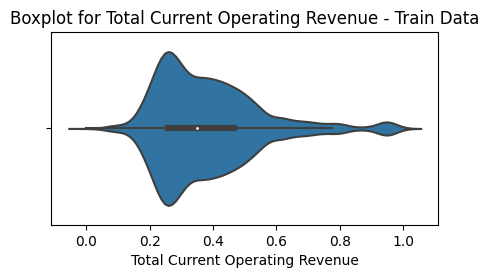

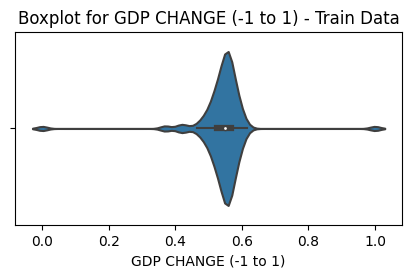

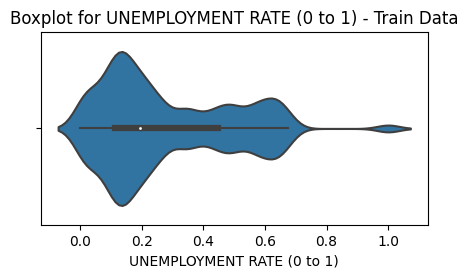

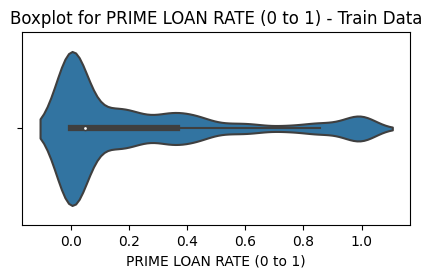

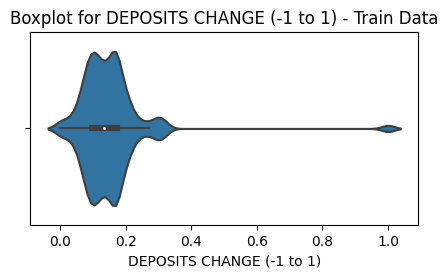

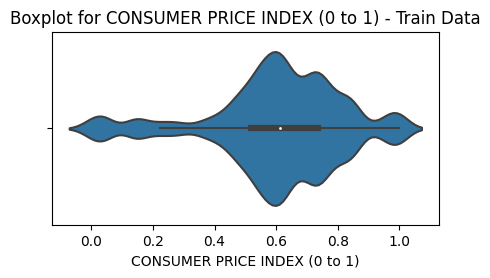

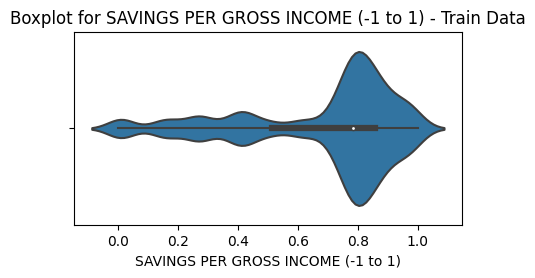

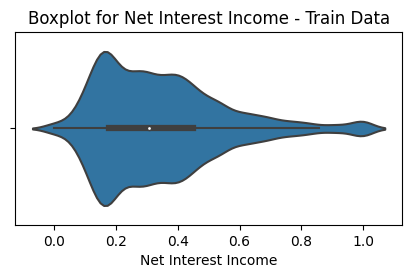

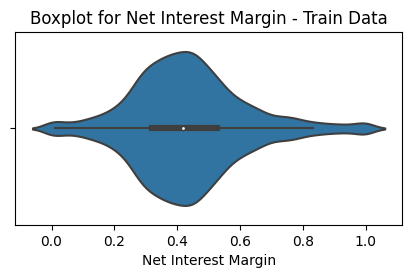

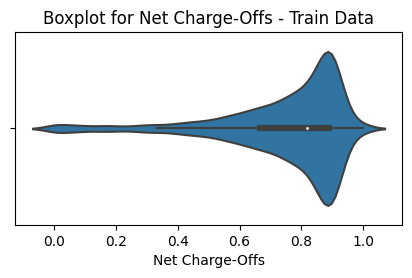

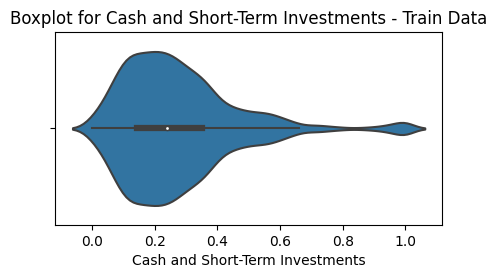

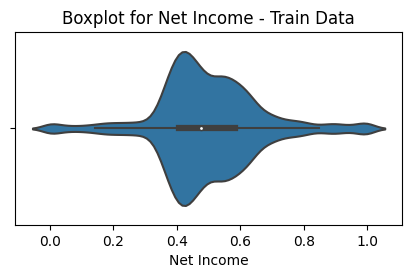

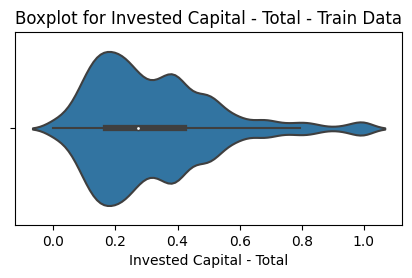

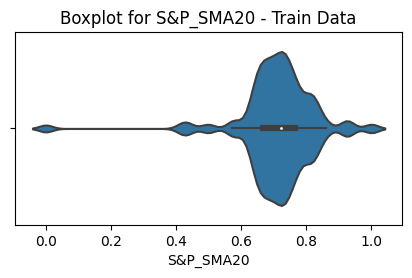

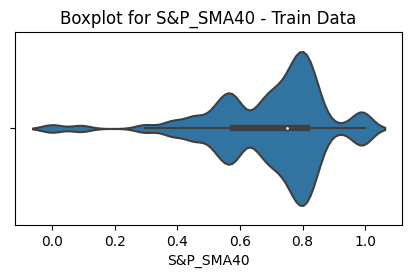

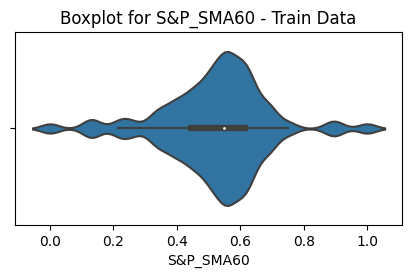

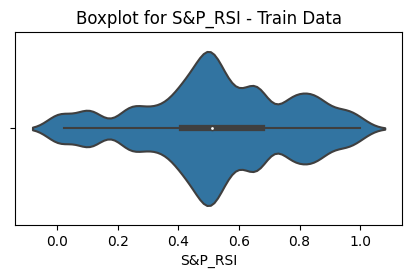

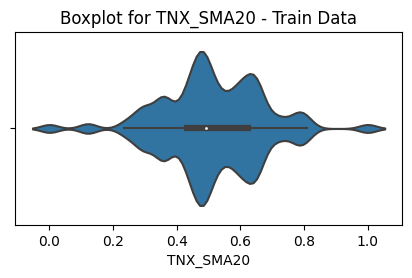

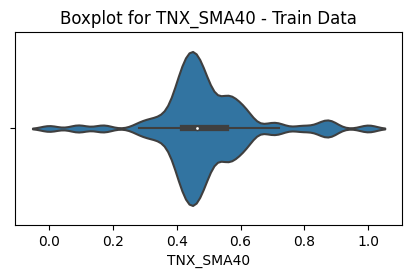

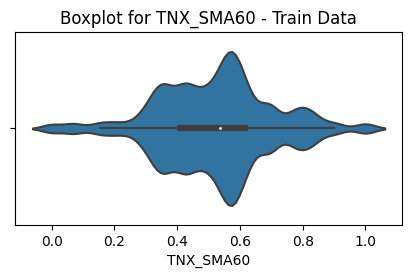

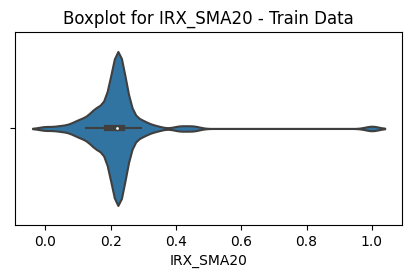

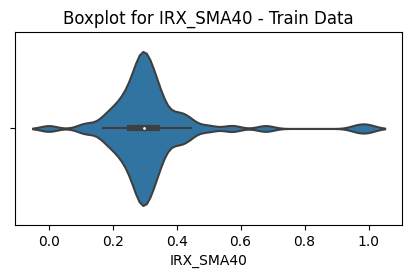

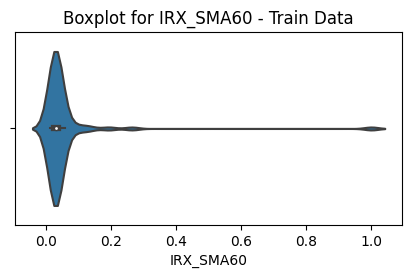

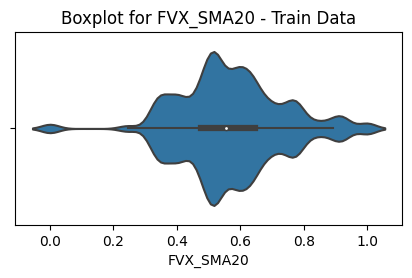

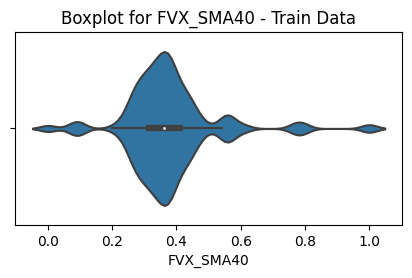

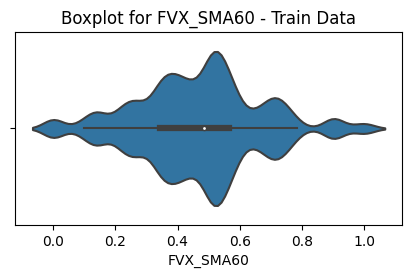

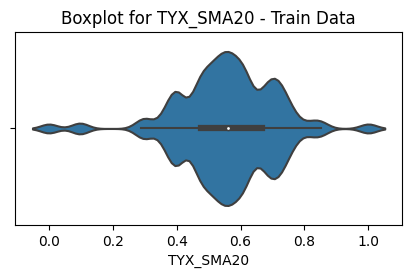

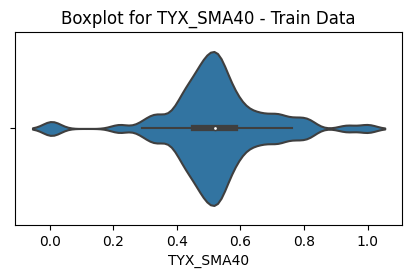

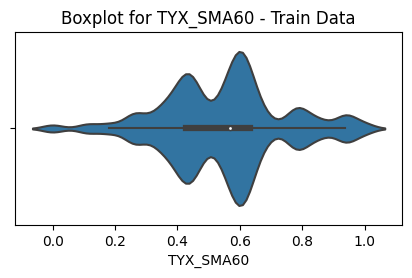

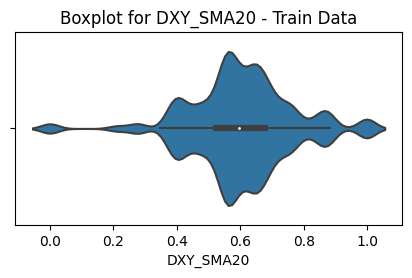

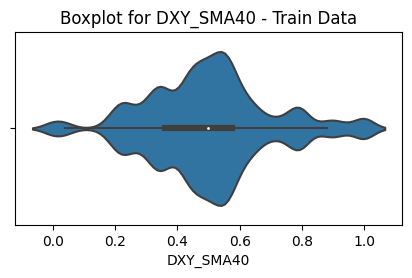

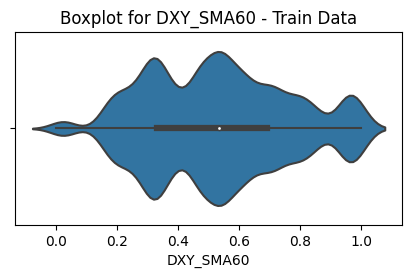

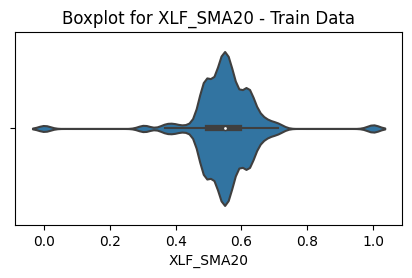

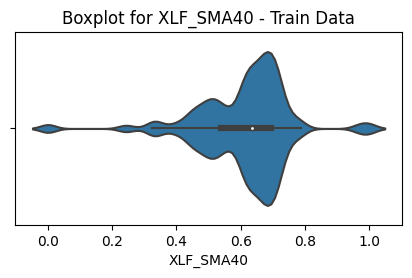

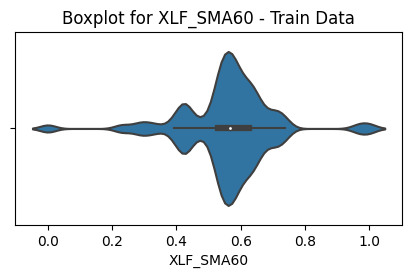

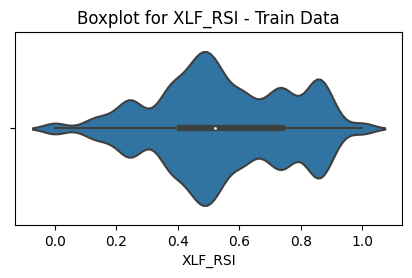

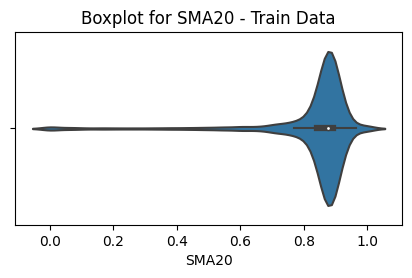

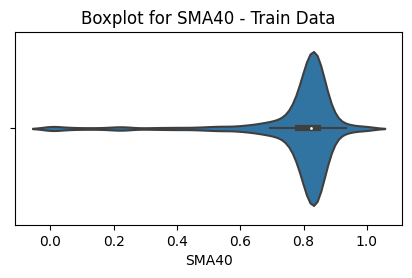

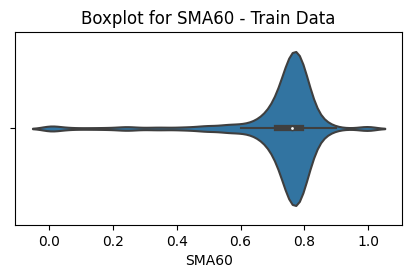

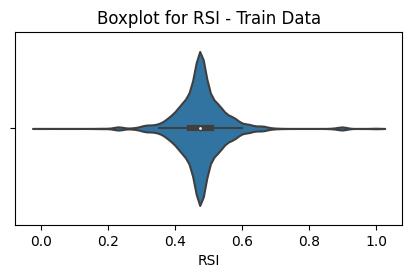

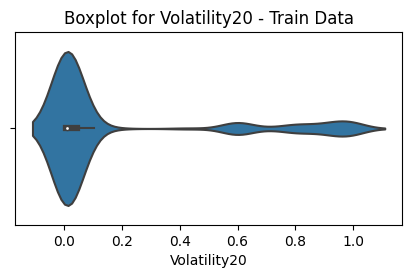

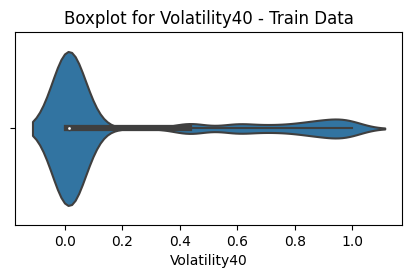

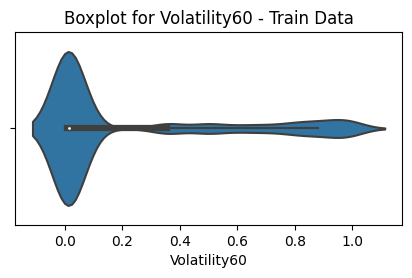

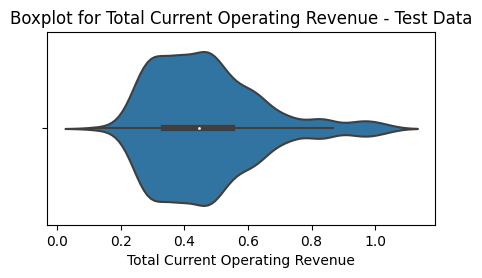

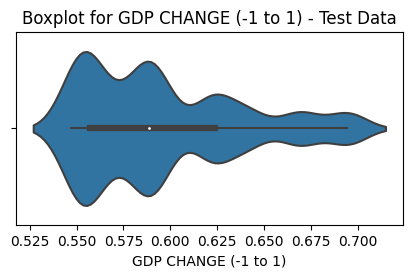

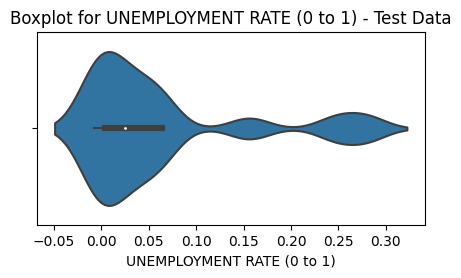

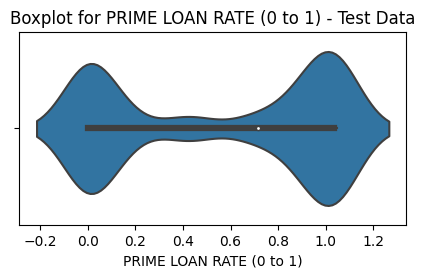

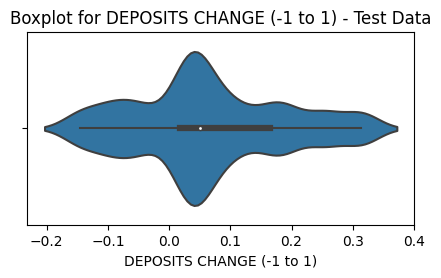

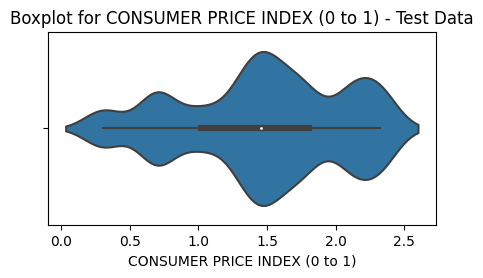

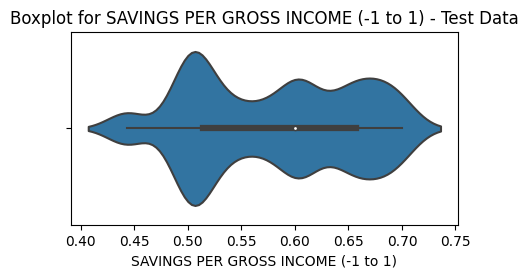

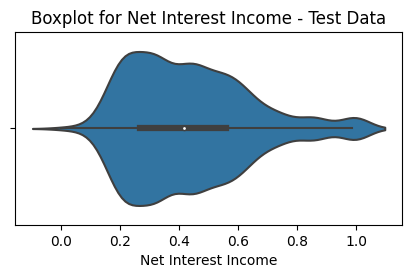

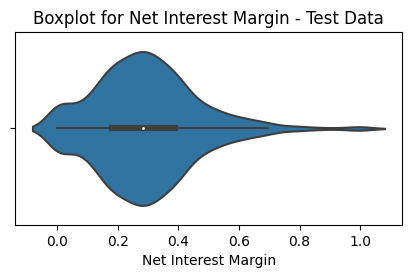

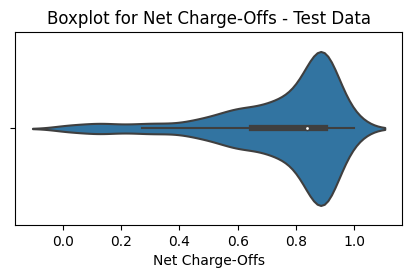

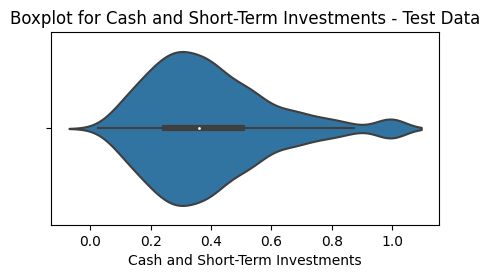

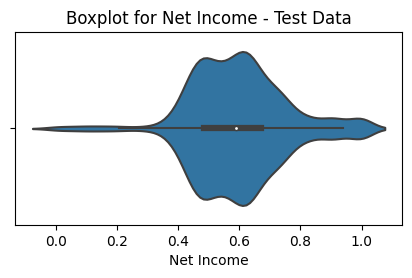

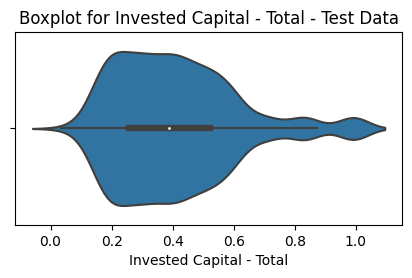

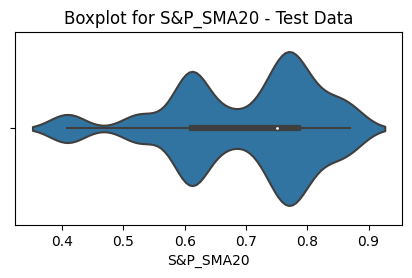

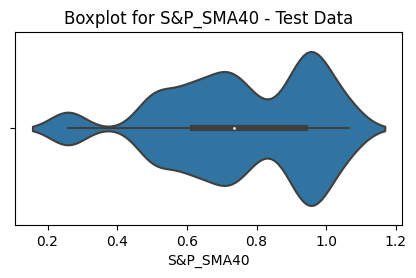

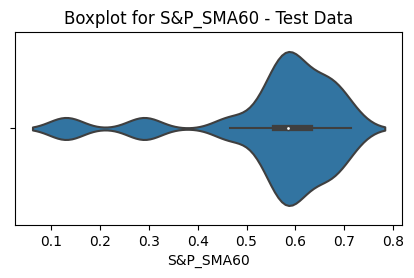

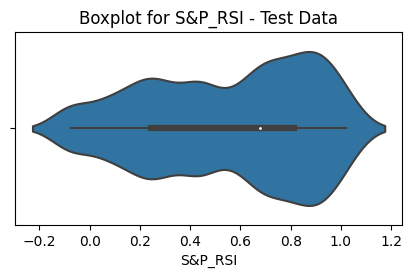

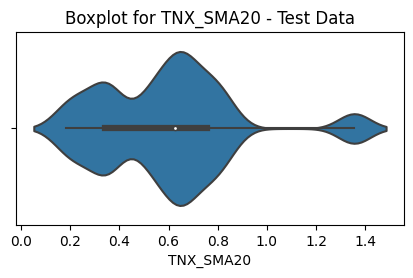

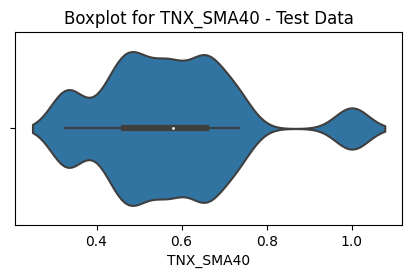

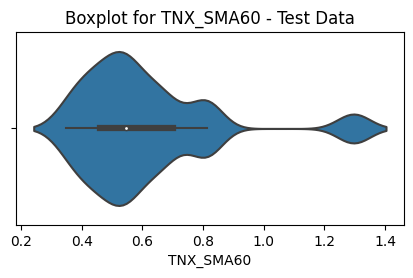

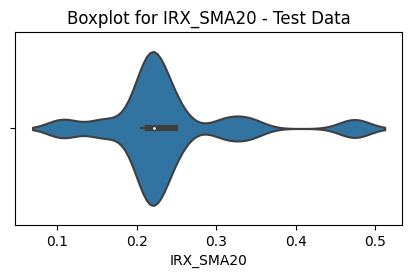

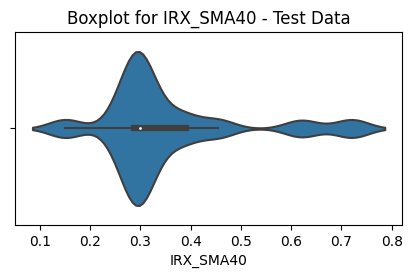

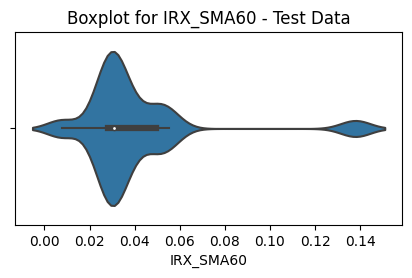

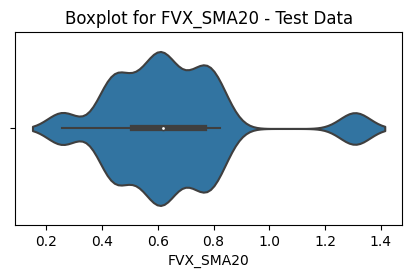

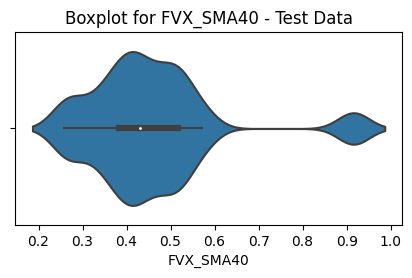

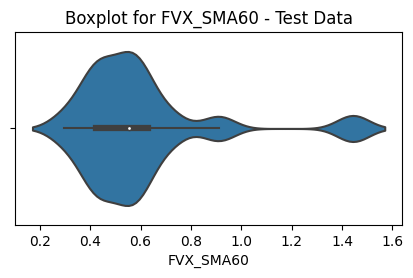

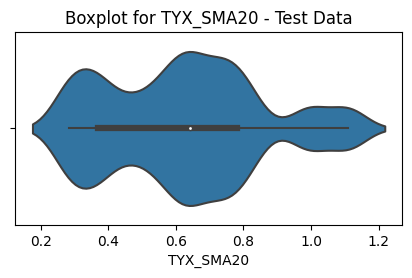

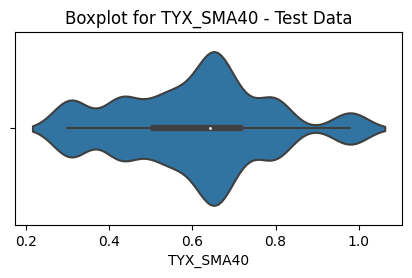

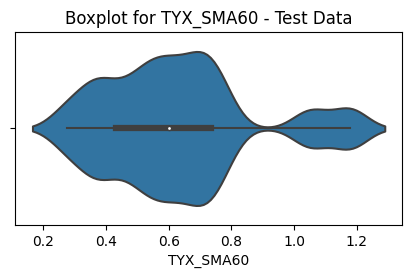

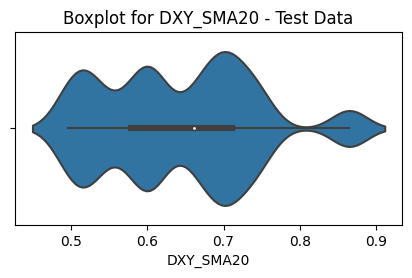

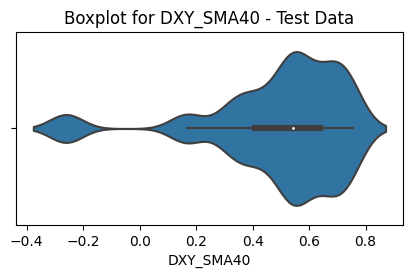

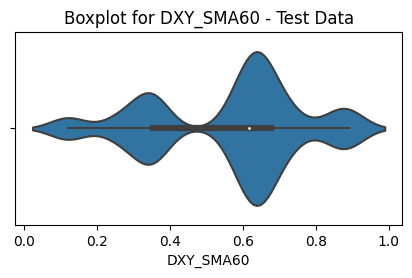

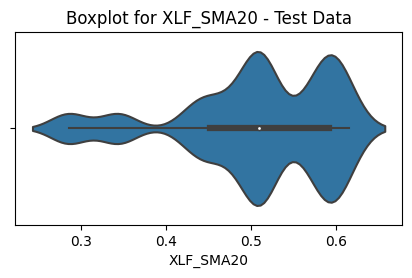

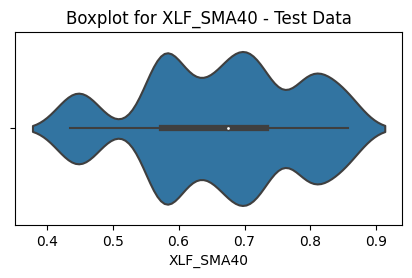

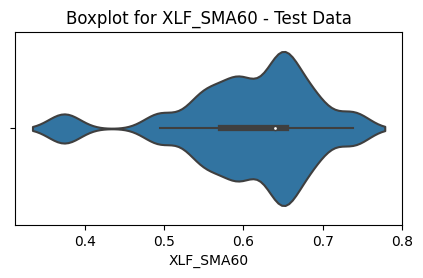

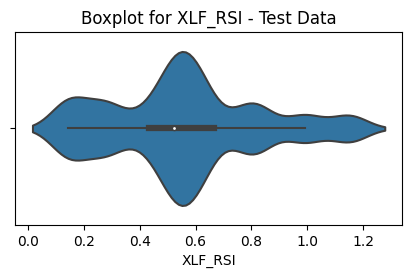

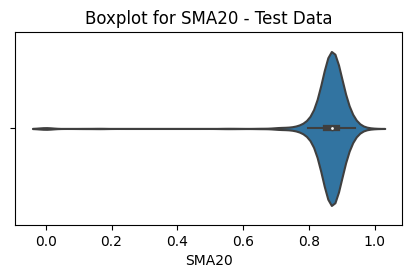

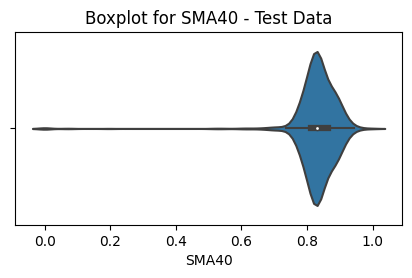

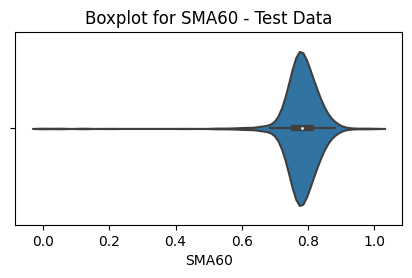

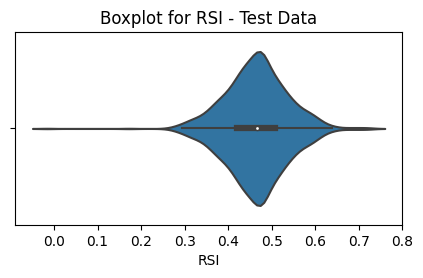

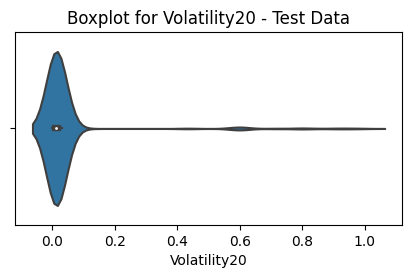

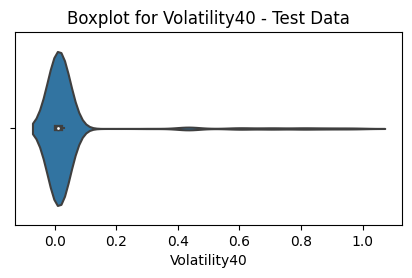

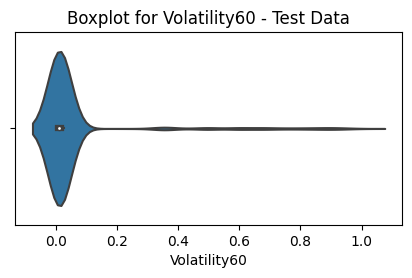

In [126]:
# plot wisker plot for train
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        plt.figure(figsize=(5, 2.5))
        sns.violinplot(x=train_df[col])
        plt.title(f"Boxplot for {col} - Train Data")
        plt.show()

# plot wisker plot for test
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        plt.figure(figsize=(5, 2.5))
        sns.violinplot(x=test_df[col])
        plt.title(f"Boxplot for {col} - Test Data")
        plt.show()

In [ ]:
# train_df.rename(columns={"Total Current Operating Revenue": "Total Current Operating Revenue (NEEDS LAGGING DO NOT USE THIS DIRECTLY)"}, inplace=True)
# test_df.rename(columns={"Total Current Operating Revenue": "Total Current Operating Revenue (NEEDS LAGGING DO NOT USE THIS DIRECTLY)"}, inplace=True)

In [128]:
train_df

,datacqtr,tic,Total Current Operating Revenue (NEEDS LAGGING DO NOT USE THIS DIRECTLY),GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,...,XLF_SMA40,XLF_SMA60,XLF_RSI,SMA20,SMA40,SMA60,RSI,Volatility20,Volatility40,Volatility60
0,2003Q2,ABVA,0.177805,0.557456,0.269504,0.198438,0.161457,0.665201,0.742857,0.026232,...,0.710890,0.711272,0.645202,0.712798,0.749492,0.753013,0.476247,0.916734,0.712517,0.745714
1,2003Q3,ABVA,0.179568,0.616419,0.269504,0.150000,0.201673,0.598968,0.728571,0.029798,...,0.698337,0.537472,0.546251,0.884125,0.818129,0.785634,0.459651,0.067026,0.605681,0.603150
2,2003Q4,ABVA,0.172497,0.588974,0.237589,0.150000,0.009003,0.543433,0.785714,0.039897,...,0.616072,0.584998,0.885068,0.760812,0.795066,0.774961,0.475722,0.802642,0.716389,0.600137
3,2004Q1,ABVA,0.170488,0.560028,0.223404,0.150000,0.199022,0.539286,0.771429,0.031195,...,0.671230,0.614431,0.625501,0.812119,0.821011,0.000000,0.470442,0.594819,0.430797,0.494592
4,2004Q2,ABVA,0.181794,0.577870,0.212766,0.150781,0.301631,0.637855,0.828571,0.036724,...,0.611101,0.465878,0.516754,0.883294,0.813442,0.693606,0.463931,0.001704,0.433373,0.354550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9203,2019Q4,ZION,0.624441,0.543011,0.000000,0.316935,0.179586,0.829274,0.800000,0.642569,...,0.688123,0.696441,0.909171,0.902486,0.833015,0.828487,0.574946,0.004705,0.003338,0.005401
9204,2020Q1,ZION,0.620248,0.429512,0.024823,0.229032,0.188084,0.817527,0.857143,0.641106,...,0.243231,0.338396,0.113245,0.741122,0.727071,0.679406,0.276463,0.047815,0.034753,0.027536
9205,2020Q2,ZION,0.614433,0.000000,1.000000,0.000000,1.000000,0.545390,0.285714,0.638556,...,0.786894,0.708562,0.426000,0.881856,0.879883,0.856550,0.462933,0.036487,0.038777,0.035758
9206,2020Q3,ZION,0.616624,1.000000,0.553191,0.000000,0.271433,0.591289,0.414286,0.641526,...,0.652927,0.646312,0.456616,0.849018,0.815369,0.778679,0.408204,0.018530,0.017206,0.017881


In [129]:
# Save the dataframes to csv files
train_df.to_csv("data/train_data_REV.csv", index=False)
test_df.to_csv("data/test_data_REV.csv", index=False)